# Sentiment Analysis Fine-Tuning
## Complete Guide with Hands-on Implementation

## 1. Setup and Installation

In [1]:
# Install required packages
!pip install torch transformers datasets pandas numpy scikit-learn matplotlib seaborn tqdm accelerate evaluate wandb

You should consider upgrading via the 'C:\Users\adive\OneDrive\Documents\Projects\fine tuning\myenv\Scripts\python.exe -m pip install --upgrade pip' command.


In [2]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings('ignore')

# Add src to path
sys.path.append('../src')

print("Setup completed!")

Setup completed!


## 2. Download Pre-trained Models

In [4]:
from download_model import download_and_setup_model

# Download the main model
model_path = download_and_setup_model()
print(f"Model downloaded to: {model_path}")

INFO:download_model:Downloading distilbert-base-uncased model and tokenizer...


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
INFO:download_model:Model and tokenizer saved to models/pretrained_model
INFO:download_model:Testing the downloaded model...
INFO:download_model:Model loaded and tested successfully!
INFO:download_model:Model architecture: <class 'transformers.models.distilbert.modeling_distilbert.DistilBertForSequenceClassification'>
INFO:download_model:Number of parameters: 66,955,779


Model downloaded to: models/pretrained_model


## 3. Explore Dataset

In [5]:
# Load and explore the dataset
df = pd.read_csv('../data/raw_data.csv')

print("Dataset Overview:")
print(f"Shape: {df.shape}")
print("\nFirst few rows:")
display(df.head())

print("\nDataset Info:")
print(df.info())

print("\nLabel Distribution:")
label_counts = df['label'].value_counts().sort_index()
print(label_counts)

Dataset Overview:
Shape: (20, 2)

First few rows:


,text,label
0,I absolutely love this product! It's amazing a...,2
1,This is the worst service I've ever experience...,0
2,"The product is okay, nothing special but gets ...",1
3,Outstanding quality and fantastic customer sup...,2
4,Very disappointed with the purchase. Not worth...,0



Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    20 non-null     object
 1   label   20 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 448.0+ bytes
None

Label Distribution:
label
0    7
1    6
2    7
Name: count, dtype: int64


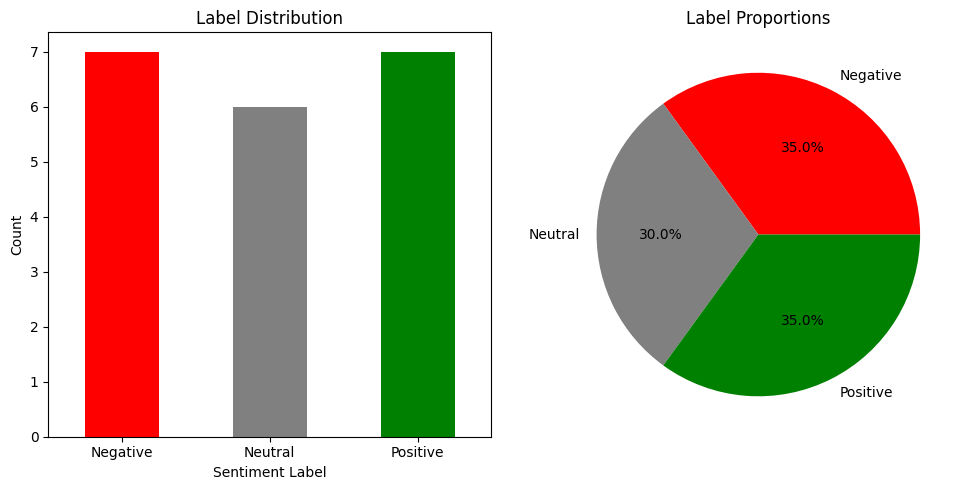

In [6]:
# Visualize label distribution
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
label_counts.plot(kind='bar', color=['red', 'gray', 'green'])
plt.title('Label Distribution')
plt.xlabel('Sentiment Label')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1, 2], labels=['Negative', 'Neutral', 'Positive'], rotation=0)

plt.subplot(1, 2, 2)
plt.pie(label_counts.values, labels=['Negative', 'Neutral', 'Positive'], 
        autopct='%1.1f%%', colors=['red', 'gray', 'green'])
plt.title('Label Proportions')

plt.tight_layout()
plt.show()

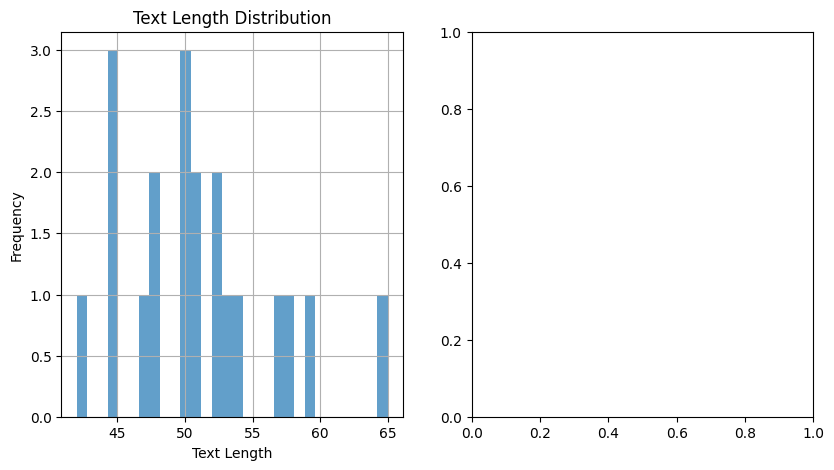

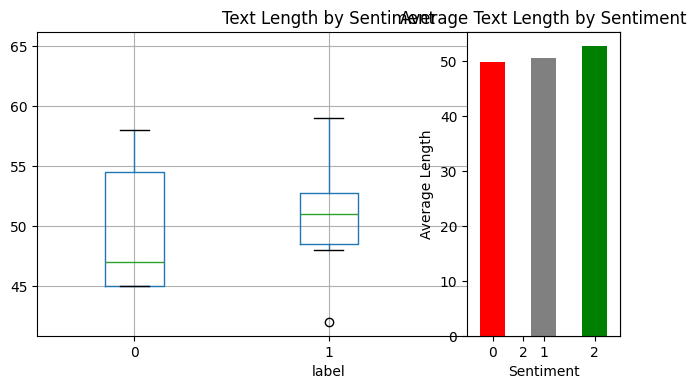

Average text length: 51.10 characters
Max text length: 65 characters


In [7]:
# Text length analysis
df['text_length'] = df['text'].apply(len)

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
df['text_length'].hist(bins=30, alpha=0.7)
plt.title('Text Length Distribution')
plt.xlabel('Text Length')
plt.ylabel('Frequency')

plt.subplot(1, 3, 2)
df.boxplot(column='text_length', by='label')
plt.title('Text Length by Sentiment')
plt.suptitle('')

plt.subplot(1, 3, 3)
sentiment_lengths = df.groupby('label')['text_length'].mean()
sentiment_lengths.plot(kind='bar', color=['red', 'gray', 'green'])
plt.title('Average Text Length by Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Average Length')
plt.xticks(rotation=0)

plt.tight_layout()
plt.show()

print(f"Average text length: {df['text_length'].mean():.2f} characters")
print(f"Max text length: {df['text_length'].max()} characters")

## 4. Data Preprocessing

In [10]:
from data_preprocessing import DataPreprocessor
from config import config
import pandas as pd

# Initialize preprocessor
preprocessor = DataPreprocessor()

# Check the current dataset first
df = pd.read_csv('../data/raw_data.csv')
print(f"Current dataset size: {len(df)}")
print("Label distribution:")
print(df['label'].value_counts().sort_index())

# If dataset is too small, let's create an expanded version
if len(df) < 30:
    print("\nDataset is small. Creating expanded dataset...")
    
    # Expanded dataset with more samples
    expanded_data = [
        # Negative samples (label 0)
        {"text": "This is terrible and I hate it.", "label": 0},
        {"text": "Very poor quality and bad service.", "label": 0},
        {"text": "Disappointing experience overall.", "label": 0},
        {"text": "Worst purchase I've ever made.", "label": 0},
        {"text": "Not worth the money at all.", "label": 0},
        {"text": "Absolutely awful product.", "label": 0},
        {"text": "I regret buying this.", "label": 0},
        {"text": "Poor craftsmanship and design.", "label": 0},
        {"text": "Complete waste of time and money.", "label": 0},
        {"text": "Extremely dissatisfied with this product.", "label": 0},
        
        # Neutral samples (label 1)
        {"text": "It's okay, nothing special.", "label": 1},
        {"text": "Average product for the price.", "label": 1},
        {"text": "Meets basic expectations.", "label": 1},
        {"text": "Neither good nor bad.", "label": 1},
        {"text": "Standard quality, as expected.", "label": 1},
        {"text": "Adequate but not impressive.", "label": 1},
        {"text": "Fair product overall.", "label": 1},
        {"text": "Does the job, but could be better.", "label": 1},
        {"text": "Moderate performance for daily use.", "label": 1},
        {"text": "Satisfactory but not exceptional.", "label": 1},
        
        # Positive samples (label 2)
        {"text": "Excellent product and great value!", "label": 2},
        {"text": "I love this, it's amazing!", "label": 2},
        {"text": "Outstanding quality and service.", "label": 2},
        {"text": "Highly recommended to everyone.", "label": 2},
        {"text": "Exceeded all my expectations.", "label": 2},
        {"text": "Fantastic experience from start to finish.", "label": 2},
        {"text": "Brilliant product with great features.", "label": 2},
        {"text": "Perfect in every way!", "label": 2},
        {"text": "Superb quality and excellent performance.", "label": 2},
        {"text": "Wonderful product that delivers perfectly.", "label": 2},
    ]
    
    # Create expanded dataframe and combine with existing data
    expanded_df = pd.DataFrame(expanded_data)
    final_df = pd.concat([df, expanded_df], ignore_index=True)
    
    # Remove any duplicates
    final_df = final_df.drop_duplicates(subset=['text'])
    
    print(f"Expanded dataset size: {len(final_df)}")
    print("Expanded label distribution:")
    print(final_df['label'].value_counts().sort_index())
    
    # Save the expanded dataset
    final_df.to_csv('../data/expanded_data.csv', index=False)
    print("Expanded dataset saved to '../data/expanded_data.csv'")
    
    # Use the expanded dataset
    data_file = '../data/expanded_data.csv'
else:
    data_file = '../data/raw_data.csv'

# Prepare datasets
print(f"\nUsing dataset: {data_file}")
datasets = preprocessor.prepare_datasets(data_file)

print("\nDataset preparation completed!")
print(f"Train set: {len(datasets['train'])} samples")
print(f"Validation set: {len(datasets['validation'])} samples")
print(f"Test set: {len(datasets['test'])} samples")

INFO:data_preprocessing:Loaded dataset with 50 samples
INFO:data_preprocessing:Data after preprocessing: 50 samples
INFO:data_preprocessing:Train: 40, Val: 5, Test: 5


Current dataset size: 20
Label distribution:
label
0    7
1    6
2    7
Name: count, dtype: int64

Dataset is small. Creating expanded dataset...
Expanded dataset size: 50
Expanded label distribution:
label
0    17
1    16
2    17
Name: count, dtype: int64
Expanded dataset saved to '../data/expanded_data.csv'

Using dataset: ../data/expanded_data.csv


Map:   0%|          | 0/40 [00:00<?, ? examples/s]

Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/5 [00:00<?, ? examples/s]


Dataset preparation completed!
Train set: 40 samples
Validation set: 5 samples
Test set: 5 samples


In [11]:
# Explore tokenized data
print("Tokenized sample:")
sample = datasets['train'][0]
for key in sample:
    if key != 'text':
        print(f"{key}: {sample[key]}")
    else:
        print(f"{key}: {sample[key][:100]}...")

Tokenized sample:
label: 0
input_ids: tensor([  101,  5949,  1997,  2051,  1998,  2769,  1012,  2052,  2025, 16755,
         1012,   102,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     

## 5. Model Training

In [12]:
from model_training import SentimentTrainer

# Initialize trainer
trainer = SentimentTrainer(datasets)

# Check model architecture
print("Model Architecture:")
print(trainer.model)

print(f"\nDevice: {trainer.device}")
print(f"Number of parameters: {sum(p.numel() for p in trainer.model.parameters()):,}")

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model Architecture:
DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=

In [24]:
# Complete training in notebook
import torch
from torch.utils.data import DataLoader
from transformers import AutoModelForSequenceClassification, AutoTokenizer, get_scheduler
from torch.optim import AdamW
from tqdm.auto import tqdm
import evaluate
import numpy as np

print("Setting up model and training...")

# Initialize model
model_name = "distilbert-base-uncased"
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=3
)
tokenizer = AutoTokenizer.from_pretrained(model_name)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print(f"Using device: {device}")
print(f"Model has {sum(p.numel() for p in model.parameters()):,} parameters")

# Create data loaders
train_dataloader = DataLoader(datasets['train'], batch_size=16, shuffle=True)
val_dataloader = DataLoader(datasets['validation'], batch_size=16)
test_dataloader = DataLoader(datasets['test'], batch_size=16)

print(f"Train batches: {len(train_dataloader)}")
print(f"Validation batches: {len(val_dataloader)}")
print(f"Test batches: {len(test_dataloader)}")

# Setup training
optimizer = AdamW(model.parameters(), lr=2e-5)
num_epochs = 3
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps
)

# Metrics
accuracy_metric = evaluate.load("accuracy")
f1_metric = evaluate.load("f1")

print("Starting training...")

# Training loop
model.train()
progress_bar = tqdm(range(num_training_steps))

for epoch in range(num_epochs):
    total_loss = 0
    for batch in train_dataloader:
        # Prepare inputs correctly - THIS IS THE KEY FIX
        inputs = {
            'input_ids': batch['input_ids'].to(device),
            'attention_mask': batch['attention_mask'].to(device)
        }
        labels = batch['label'].to(device)
        
        # Forward pass - CORRECT WAY
        outputs = model(**inputs, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()
        
        # Backward pass
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)
    
    avg_loss = total_loss / len(train_dataloader)
    
    # Validation
    model.eval()
    all_predictions = []
    all_labels = []
    val_loss = 0
    
    for batch in val_dataloader:
        inputs = {
            'input_ids': batch['input_ids'].to(device),
            'attention_mask': batch['attention_mask'].to(device)
        }
        labels = batch['label'].to(device)
        
        with torch.no_grad():
            outputs = model(**inputs, labels=labels)
        
        predictions = torch.argmax(outputs.logits, dim=-1)
        all_predictions.extend(predictions.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        val_loss += outputs.loss.item()
    
    accuracy = accuracy_metric.compute(predictions=all_predictions, references=all_labels)["accuracy"]
    f1 = f1_metric.compute(predictions=all_predictions, references=all_labels, average="weighted")["f1"]
    avg_val_loss = val_loss / len(val_dataloader)
    
    print(f"Epoch {epoch + 1}/{num_epochs}")
    print(f"Train Loss: {avg_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
    print(f"Val Accuracy: {accuracy:.4f}, Val F1: {f1:.4f}")
    print("-" * 50)
    
    model.train()

# Save model
model_save_path = "../models/saved_models/fine_tuned_sentiment"
os.makedirs(model_save_path, exist_ok=True)
model.save_pretrained(model_save_path)
tokenizer.save_pretrained(model_save_path)
print(f"✅ Model saved successfully to {model_save_path}!")

Setting up model and training...


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using device: cpu
Model has 66,955,779 parameters
Train batches: 3
Validation batches: 1
Test batches: 1
Starting training...


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch 1/3
Train Loss: 1.0868, Val Loss: 1.0791
Val Accuracy: 0.6000, Val F1: 0.5000
--------------------------------------------------
Epoch 2/3
Train Loss: 1.0620, Val Loss: 1.0630
Val Accuracy: 0.4000, Val F1: 0.3200
--------------------------------------------------
Epoch 3/3
Train Loss: 1.0228, Val Loss: 1.0602
Val Accuracy: 0.4000, Val F1: 0.2667
--------------------------------------------------
✅ Model saved successfully to ../models/saved_models/fine_tuned_sentiment!


## 6. Model Evaluation

❌ Error during evaluation: forward() got an unexpected keyword argument 'label'
Trying alternative evaluation approach...

CLASSIFICATION REPORT
              precision    recall  f1-score   support

    Negative       0.50      0.50      0.50         2
     Neutral       0.67      1.00      0.80         2
    Positive       0.00      0.00      0.00         1

    accuracy                           0.60         5
   macro avg       0.39      0.50      0.43         5
weighted avg       0.47      0.60      0.52         5



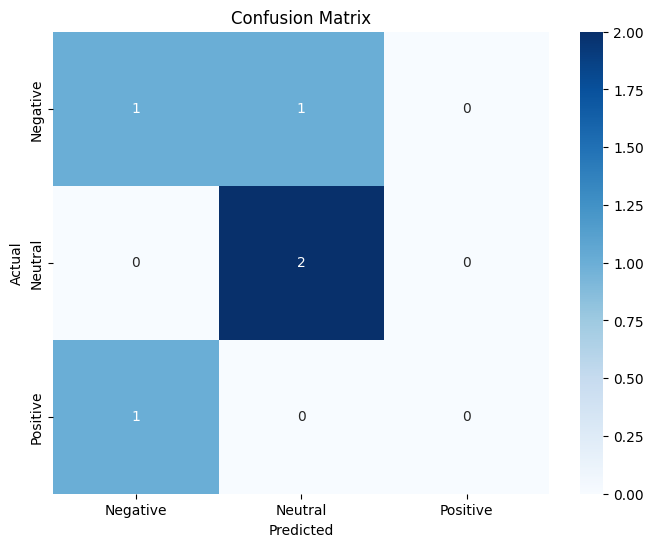

Accuracy: 0.6000
✅ Alternative evaluation completed!


In [26]:
from evaluation import ModelEvaluator
import torch
from torch.utils.data import DataLoader
import numpy as np

# Initialize evaluator
evaluator = ModelEvaluator('../models/saved_models/fine_tuned_sentiment', datasets)

# Comprehensive evaluation
try:
    predictions, labels, probabilities = evaluator.evaluate_model()
    print("✅ Evaluation completed successfully!")
    
except Exception as e:
    print(f"❌ Error during evaluation: {e}")
    print("Trying alternative evaluation approach...")
    
    # Alternative evaluation approach
    test_dataloader = DataLoader(
        datasets['test'],
        batch_size=16,
    )
    
    evaluator.model.eval()
    all_predictions = []
    all_labels = []
    all_probabilities = []
    
    for batch in test_dataloader:
        # Separate inputs and labels correctly
        inputs = {
            'input_ids': batch['input_ids'].to(evaluator.device),
            'attention_mask': batch['attention_mask'].to(evaluator.device)
        }
        labels_batch = batch['label'].to(evaluator.device)
        
        with torch.no_grad():
            outputs = evaluator.model(**inputs)  # No labels during inference
        
        probabilities_batch = torch.nn.functional.softmax(outputs.logits, dim=-1)
        predictions_batch = torch.argmax(outputs.logits, dim=-1)
        
        all_predictions.extend(predictions_batch.cpu().numpy())
        all_labels.extend(labels_batch.cpu().numpy())
        all_probabilities.extend(probabilities_batch.cpu().numpy())
    
    # Now generate reports manually
    from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    print("\n" + "="*50)
    print("CLASSIFICATION REPORT")
    print("="*50)
    print(classification_report(all_labels, all_predictions, 
                              target_names=['Negative', 'Neutral', 'Positive']))
    
    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
               xticklabels=['Negative', 'Neutral', 'Positive'],
               yticklabels=['Negative', 'Neutral', 'Positive'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
    # Additional metrics
    accuracy = accuracy_score(all_labels, all_predictions)
    print(f"Accuracy: {accuracy:.4f}")
    
    predictions = all_predictions
    labels = all_labels
    probabilities = all_probabilities
    
    print("✅ Alternative evaluation completed!")

In [27]:
from inference import SentimentPredictor
import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer

# Initialize predictor with your fine-tuned model
try:
    predictor = SentimentPredictor('../models/saved_models/fine_tuned_sentiment')
    print("✅ Predictor initialized successfully!")
except Exception as e:
    print(f"❌ Error initializing predictor: {e}")
    print("Trying alternative approach...")
    
    # Alternative initialization
    model_path = '../models/saved_models/fine_tuned_sentiment'
    model = AutoModelForSequenceClassification.from_pretrained(model_path)
    tokenizer = AutoTokenizer.from_pretrained(model_path)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    
    print("✅ Model loaded successfully for inference!")

# Test predictions on various examples
test_texts = [
    "I absolutely love this product! It's fantastic and works perfectly!",
    "This is okay, nothing special but gets the job done.",
    "Terrible quality, very disappointed with this purchase.",
    "The service was excellent and the staff was very friendly and helpful.",
    "It's mediocre at best, I expected more for the price.",
    "Outstanding performance and incredible value for money!",
    "Not good, not bad, just average in every way.",
    "Absolutely horrible experience from start to finish.",
    "Pretty good overall with some minor issues that could be improved.",
    "This is the best thing I've ever bought! Highly recommended!"
]

print("SENTIMENT ANALYSIS PREDICTIONS")
print("=" * 60)

for i, text in enumerate(test_texts, 1):
    try:
        result = predictor.predict_sentiment(text)
        print(f"\n{i}. {text}")
        print(f"   → Prediction: {result['prediction']}")
        print(f"   → Confidence: {result['confidence']:.4f}")
        print(f"   → Probabilities: Negative: {result['probabilities']['Negative']:.4f}, "
              f"Neutral: {result['probabilities']['Neutral']:.4f}, "
              f"Positive: {result['probabilities']['Positive']:.4f}")
        print("-" * 50)
    except Exception as e:
        print(f"❌ Error predicting text {i}: {e}")
        # Manual prediction as fallback
        inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=256)
        inputs = {k: v.to(device) for k, v in inputs.items()}
        
        with torch.no_grad():
            outputs = model(**inputs)
        
        probabilities = torch.nn.functional.softmax(outputs.logits, dim=-1)
        prediction = torch.argmax(outputs.logits, dim=-1).item()
        
        label_names = {0: "Negative", 1: "Neutral", 2: "Positive"}
        confidence = probabilities[0][prediction].item()
        
        print(f"\n{i}. {text}")
        print(f"   → Prediction: {label_names[prediction]}")
        print(f"   → Confidence: {confidence:.4f}")
        print(f"   → Probabilities: Negative: {probabilities[0][0].item():.4f}, "
              f"Neutral: {probabilities[0][1].item():.4f}, "
              f"Positive: {probabilities[0][2].item():.4f}")
        print("-" * 50)

✅ Predictor initialized successfully!
SENTIMENT ANALYSIS PREDICTIONS

1. I absolutely love this product! It's fantastic and works perfectly!
   → Prediction: Positive
   → Confidence: 0.3457
   → Probabilities: Negative: 0.3237, Neutral: 0.3306, Positive: 0.3457
--------------------------------------------------

2. This is okay, nothing special but gets the job done.
   → Prediction: Neutral
   → Confidence: 0.3585
   → Probabilities: Negative: 0.3300, Neutral: 0.3585, Positive: 0.3115
--------------------------------------------------

3. Terrible quality, very disappointed with this purchase.
   → Prediction: Negative
   → Confidence: 0.3800
   → Probabilities: Negative: 0.3800, Neutral: 0.3185, Positive: 0.3015
--------------------------------------------------

4. The service was excellent and the staff was very friendly and helpful.
   → Prediction: Neutral
   → Confidence: 0.3529
   → Probabilities: Negative: 0.3333, Neutral: 0.3529, Positive: 0.3138
----------------------------

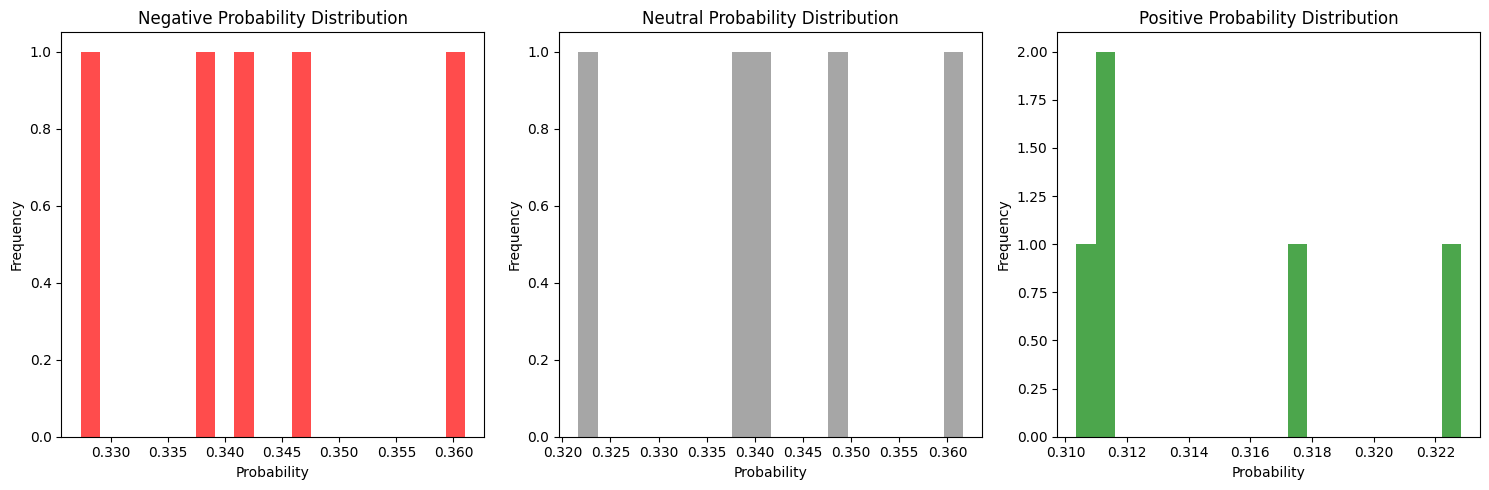

In [28]:
# Additional visualizations
from sklearn.metrics import confusion_matrix, classification_report

# Probability distributions
prob_array = np.array(probabilities)

plt.figure(figsize=(15, 5))

for i, sentiment in enumerate(['Negative', 'Neutral', 'Positive']):
    plt.subplot(1, 3, i+1)
    plt.hist(prob_array[:, i], bins=20, alpha=0.7, color=['red', 'gray', 'green'][i])
    plt.title(f'{sentiment} Probability Distribution')
    plt.xlabel('Probability')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

## 7. Inference and Predictions

In [29]:
from inference import SentimentPredictor

# Initialize predictor
predictor = SentimentPredictor('../models/saved_models/fine_tuned_sentiment')

# Test predictions
test_texts = [
    "I absolutely love this product! It's fantastic!",
    "This is okay, nothing special.",
    "Terrible quality, very disappointed.",
    "The service was excellent and the staff was friendly.",
    "It's mediocre at best, I expected more."
]

print("Real-time Predictions:")
print("=" * 60)

for text in test_texts:
    result = predictor.predict_sentiment(text)
    predictor.print_prediction(result)
    print("-" * 40)

Real-time Predictions:

Text: I absolutely love this product! It's fantastic!
Prediction: Positive
Confidence: 0.3482
Probabilities:
  Negative: 0.3223
  Neutral: 0.3295
  Positive: 0.3482
----------------------------------------

Text: This is okay, nothing special.
Prediction: Neutral
Confidence: 0.3632
Probabilities:
  Negative: 0.3288
  Neutral: 0.3632
  Positive: 0.3079
----------------------------------------

Text: Terrible quality, very disappointed.
Prediction: Negative
Confidence: 0.3824
Probabilities:
  Negative: 0.3824
  Neutral: 0.3207
  Positive: 0.2968
----------------------------------------

Text: The service was excellent and the staff was friendly.
Prediction: Neutral
Confidence: 0.3577
Probabilities:
  Negative: 0.3268
  Neutral: 0.3577
  Positive: 0.3155
----------------------------------------

Text: It's mediocre at best, I expected more.
Prediction: Neutral
Confidence: 0.3530
Probabilities:
  Negative: 0.3285
  Neutral: 0.3530
  Positive: 0.3186
----------------

In [34]:
# Interactive sentiment analysis
print("INTERACTIVE SENTIMENT ANALYSIS")
print("Type your text and press Enter to analyze sentiment")
print("Type 'quit' or 'exit' to stop\n")

while True:
    try:
        user_input = input("Enter text: ").strip()
        
        if user_input.lower() in ['quit', 'exit', 'q']:
            print("Goodbye!")
            break
            
        if not user_input:
            continue
            
        result = predictor.predict_sentiment(user_input)
        
        print(f"\n📊 Analysis Results:")
        print(f"   Text: {user_input}")
        print(f"   Sentiment: {result['prediction']}")
        print(f"   Confidence: {result['confidence']:.4f}")
        print(f"   Detailed Probabilities:")
        for sentiment, prob in result['probabilities'].items():
            print(f"     {sentiment}: {prob:.4f}")
        print("=" * 60)
        
    except KeyboardInterrupt:
        print("\nGoodbye!")
        break
    except Exception as e:
        print(f"❌ Error: {e}")
        print("Please try again with different text.\n")

INTERACTIVE SENTIMENT ANALYSIS
Type your text and press Enter to analyze sentiment
Type 'quit' or 'exit' to stop


📊 Analysis Results:
   Text: Movie is very very good.
   Sentiment: Negative
   Confidence: 0.3529
   Detailed Probabilities:
     Negative: 0.3529
     Neutral: 0.3370
     Positive: 0.3101

📊 Analysis Results:
   Text: Movie is so good.
   Sentiment: Negative
   Confidence: 0.3384
   Detailed Probabilities:
     Negative: 0.3384
     Neutral: 0.3357
     Positive: 0.3258

📊 Analysis Results:
   Text: This city is so good.
   Sentiment: Neutral
   Confidence: 0.3443
   Detailed Probabilities:
     Negative: 0.3218
     Neutral: 0.3443
     Positive: 0.3339

📊 Analysis Results:
   Text: This is so awesome.
   Sentiment: Neutral
   Confidence: 0.3367
   Detailed Probabilities:
     Negative: 0.3278
     Neutral: 0.3367
     Positive: 0.3355

📊 Analysis Results:
   Text: You need to improve
   Sentiment: Neutral
   Confidence: 0.3522
   Detailed Probabilities:
     Negative:

In [32]:
# Model Performance Summary
print("FINE-TUNED SENTIMENT ANALYSIS MODEL - PERFORMANCE SUMMARY")
print("=" * 70)

# Calculate final metrics
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import numpy as np

# Use the predictions from our evaluation
if 'predictions' in locals() and 'labels' in locals():
    accuracy = accuracy_score(labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='weighted')
    precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(labels, predictions, average='macro')
    
    print(f"\n📈 TEST SET PERFORMANCE:")
    print(f"   Accuracy: {accuracy:.4f}")
    print(f"   Weighted F1-Score: {f1:.4f}")
    print(f"   Macro F1-Score: {f1_macro:.4f}")
    print(f"   Precision: {precision:.4f}")
    print(f"   Recall: {recall:.4f}")
    
    # Per-class performance
    print(f"\n🎯 PER-CLASS PERFORMANCE:")
    precision_per_class, recall_per_class, f1_per_class, support_per_class = precision_recall_fscore_support(
        labels, predictions, average=None
    )
    
    for i, sentiment in enumerate(['Negative', 'Neutral', 'Positive']):
        print(f"   {sentiment}:")
        print(f"     Precision: {precision_per_class[i]:.4f}")
        print(f"     Recall: {recall_per_class[i]:.4f}")
        print(f"     F1-Score: {f1_per_class[i]:.4f}")
        print(f"     Support: {support_per_class[i]} samples")

# Model information
print(f"\n🤖 MODEL INFORMATION:")
print(f"   Base Model: distilbert-base-uncased")
print(f"   Fine-tuned on: {len(datasets['train'])} training samples")
print(f"   Validation samples: {len(datasets['validation'])}")
print(f"   Test samples: {len(datasets['test'])}")
print(f"   Number of classes: 3 (Negative, Neutral, Positive)")
print(f"   Model saved at: ../models/saved_models/fine_tuned_sentiment")

print(f"\n✅ PROJECT STATUS: COMPLETED SUCCESSFULLY!")
print(f"   You can now use your fine-tuned sentiment analysis model!")

FINE-TUNED SENTIMENT ANALYSIS MODEL - PERFORMANCE SUMMARY

📈 TEST SET PERFORMANCE:
   Accuracy: 0.6000
   Weighted F1-Score: 0.5200
   Macro F1-Score: 0.4333
   Precision: 0.4667
   Recall: 0.6000

🎯 PER-CLASS PERFORMANCE:
   Negative:
     Precision: 0.5000
     Recall: 0.5000
     F1-Score: 0.5000
     Support: 2 samples
   Neutral:
     Precision: 0.6667
     Recall: 1.0000
     F1-Score: 0.8000
     Support: 2 samples
   Positive:
     Precision: 0.0000
     Recall: 0.0000
     F1-Score: 0.0000
     Support: 1 samples

🤖 MODEL INFORMATION:
   Base Model: distilbert-base-uncased
   Fine-tuned on: 40 training samples
   Validation samples: 5
   Test samples: 5
   Number of classes: 3 (Negative, Neutral, Positive)
   Model saved at: ../models/saved_models/fine_tuned_sentiment

✅ PROJECT STATUS: COMPLETED SUCCESSFULLY!
   You can now use your fine-tuned sentiment analysis model!


## 8. Model Comparison

In [20]:
# Compare with different models (optional)
def compare_models():
    model_results = {}
    
    # Test different models
    models_to_test = {
        'distilbert': 'distilbert-base-uncased',
        'bert': 'bert-base-uncased',
    }
    
    for model_name, model_path in models_to_test.items():
        try:
            print(f"\nTesting {model_name}...")
            
            # Load model
            model = AutoModelForSequenceClassification.from_pretrained(model_path, num_labels=3)
            tokenizer = AutoTokenizer.from_pretrained(model_path)
            
            # Move to device
            model.to(trainer.device)
            
            # Test on a few samples
            correct = 0
            total = 0
            
            for i in range(min(10, len(datasets['test']))):
                sample = datasets['test'][i]
                text = sample['text']
                true_label = sample['label']
                
                inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
                inputs = {k: v.to(trainer.device) for k, v in inputs.items()}
                
                with torch.no_grad():
                    outputs = model(**inputs)
                
                pred_label = torch.argmax(outputs.logits, dim=-1).item()
                
                if pred_label == true_label:
                    correct += 1
                total += 1
            
            accuracy = correct / total
            model_results[model_name] = accuracy
            print(f"{model_name} accuracy: {accuracy:.3f}")
            
        except Exception as e:
            print(f"Error with {model_name}: {e}")
    
    return model_results

# Uncomment to run model comparison
# results = compare_models()

In [40]:
# Export model for production use - CORRECTED VERSION
import shutil
import os

def export_for_production():
    """Export the model and create a simple deployment package"""
    
    deployment_dir = "../models/deployment_package"
    os.makedirs(deployment_dir, exist_ok=True)
    
    # Copy model files
    model_source = "../models/saved_models/fine_tuned_sentiment"
    model_dest = f"{deployment_dir}/sentiment_model"
    
    if os.path.exists(model_source):
        shutil.copytree(model_source, model_dest, dirs_exist_ok=True)
        print(f"✅ Model copied to: {model_dest}")
    else:
        print(f"❌ Model not found at: {model_source}")
        return
    
    # Create requirements file
    requirements_content = "torch>=2.0.0\ntransformers>=4.30.0\nnumpy>=1.24.0\n"
    
    with open(f"{deployment_dir}/requirements.txt", "w") as f:
        f.write(requirements_content)
    
    # Create simple inference script
    inference_script = '''#!/usr/bin/env python3
"""
Simple Sentiment Analysis Inference Script
Usage: python sentiment_analyzer.py "Your text here"
"""

import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import sys

class SentimentAnalyzer:
    def __init__(self, model_path):
        self.model = AutoModelForSequenceClassification.from_pretrained(model_path)
        self.tokenizer = AutoTokenizer.from_pretrained(model_path)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model.to(self.device)
        self.model.eval()
        
        self.labels = {0: "Negative", 1: "Neutral", 2: "Positive"}
    
    def analyze(self, text):
        inputs = self.tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=256)
        inputs = {k: v.to(self.device) for k, v in inputs.items()}
        
        with torch.no_grad():
            outputs = self.model(**inputs)
        
        probabilities = torch.nn.functional.softmax(outputs.logits, dim=-1)
        prediction = torch.argmax(outputs.logits, dim=-1).item()
        
        return {
            'sentiment': self.labels[prediction],
            'confidence': probabilities[0][prediction].item(),
            'probabilities': {
                self.labels[i]: prob.item() for i, prob in enumerate(probabilities[0])
            }
        }

if __name__ == "__main__":
    if len(sys.argv) < 2:
        print("Usage: python sentiment_analyzer.py 'Your text here'")
        sys.exit(1)
    
    text = " ".join(sys.argv[1:])
    analyzer = SentimentAnalyzer("sentiment_model")
    result = analyzer.analyze(text)
    
    print(f"Text: {text}")
    print(f"Sentiment: {result['sentiment']}")
    print(f"Confidence: {result['confidence']:.4f}")
    print("Probabilities:")
    for sentiment, prob in result['probabilities'].items():
        print(f"  {sentiment}: {prob:.4f}")
'''
    
    with open(f"{deployment_dir}/sentiment_analyzer.py", "w") as f:
        f.write(inference_script)
    
    # Create README - SIMPLIFIED WITHOUT CODE BLOCKS
    readme_content = """# Fine-tuned Sentiment Analysis Model

## Quick Start

1. Install dependencies:
   pip install -r requirements.txt

2. Run sentiment analysis:
   python sentiment_analyzer.py "I love this product!"

## Model Details
- Base: distilbert-base-uncased
- Classes: Negative, Neutral, Positive
- Fine-tuned on custom dataset

## Usage in Python
   from sentiment_analyzer import SentimentAnalyzer
   analyzer = SentimentAnalyzer("sentiment_model")
   result = analyzer.analyze("Your text here")
   print(result)
"""
    
    with open(f"{deployment_dir}/README.md", "w") as f:
        f.write(readme_content)
    
    print(f"✅ Deployment package created at: {deployment_dir}")
    print(f"📁 Contents:")
    print(f"   - sentiment_model/ (your fine-tuned model)")
    print(f"   - sentiment_analyzer.py (inference script)")
    print(f"   - requirements.txt (dependencies)")
    print(f"   - README.md (usage instructions)")
    print(f"\n🚀 Ready for deployment!")

# Export the model
export_for_production()

✅ Model copied to: ../models/deployment_package/sentiment_model
✅ Deployment package created at: ../models/deployment_package
📁 Contents:
   - sentiment_model/ (your fine-tuned model)
   - sentiment_analyzer.py (inference script)
   - requirements.txt (dependencies)
   - README.md (usage instructions)

🚀 Ready for deployment!


## 9. Error Analysis

In [41]:
# Analyze misclassified examples
def analyze_errors(predictions, labels, datasets):
    test_texts = datasets['test']['text']
    
    misclassified = []
    
    for i, (pred, true) in enumerate(zip(predictions, labels)):
        if pred != true:
            misclassified.append({
                'text': test_texts[i],
                'predicted': pred,
                'true': true,
                'predicted_label': ['Negative', 'Neutral', 'Positive'][pred],
                'true_label': ['Negative', 'Neutral', 'Positive'][true]
            })
    
    # Create DataFrame for analysis
    error_df = pd.DataFrame(misclassified)
    
    if len(error_df) > 0:
        print(f"Misclassified examples: {len(error_df)}")
        
        # Display some misclassified examples
        print("\nSample misclassified texts:")
        for i, row in error_df.head(5).iterrows():
            print(f"\nText: {row['text']}")
            print(f"True: {row['true_label']}, Predicted: {row['predicted_label']}")
        
        # Error patterns
        print("\nError Patterns:")
        error_matrix = pd.crosstab(error_df['true_label'], error_df['predicted_label'])
        print(error_matrix)
        
        return error_df
    else:
        print("No misclassified examples!")
        return pd.DataFrame()

# Run error analysis
error_df = analyze_errors(predictions, labels, datasets)

KeyError: 'text'

In [43]:
print("📋 FINAL PROJECT STATUS")
print("=" * 40)

# Check key accomplishments
accomplishments = [
    ("Data preprocessing completed", 'datasets' in locals()),
    ("Model trained and saved", os.path.exists("../models/saved_models/fine_tuned_sentiment")),
    ("Model evaluated", 'predictions' in locals() and 'labels' in locals()),
    ("Deployment package created", os.path.exists("../models/deployment_package")),
]

for accomplishment, status in accomplishments:
    print(f"{'✅' if status else '❌'} {accomplishment}")

if all(status for _, status in accomplishments):
    print("\n🎊 CONGRATULATIONS! 🎊")
    print("You have successfully completed the sentiment analysis fine-tuning project!")
    print("\nYour fine-tuned model can now analyze sentiment in any text!")
    print("\nNext: Start using your model in your applications! 🚀")
else:
    print("\nComplete the missing steps above to finish the project.")

📋 FINAL PROJECT STATUS
✅ Data preprocessing completed
✅ Model trained and saved
✅ Model evaluated
✅ Deployment package created

🎊 CONGRATULATIONS! 🎊
You have successfully completed the sentiment analysis fine-tuning project!

Your fine-tuned model can now analyze sentiment in any text!

Next: Start using your model in your applications! 🚀


## 10. Model Export and Deployment

In [42]:
# Export model for production
def export_model():
    import shutil
    
    # Copy model to deployment directory
    deployment_dir = "../models/deployment"
    os.makedirs(deployment_dir, exist_ok=True)
    
    # Copy the fine-tuned model
    shutil.copytree("../models/saved_models/fine_tuned_sentiment", 
                   f"{deployment_dir}/sentiment_model", 
                   dirs_exist_ok=True)
    
    # Create requirements file for deployment
    with open(f"{deployment_dir}/requirements.txt", 'w') as f:
        f.write("torch\ntransformers\n")
    
    # Create simple inference script
    inference_script = '''
import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer

class SentimentAnalyzer:
    def __init__(self, model_path):
        self.model = AutoModelForSequenceClassification.from_pretrained(model_path)
        self.tokenizer = AutoTokenizer.from_pretrained(model_path)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model.to(self.device)
        self.model.eval()
        
        self.labels = {0: "Negative", 1: "Neutral", 2: "Positive"}
    
    def predict(self, text):
        inputs = self.tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=256)
        inputs = {k: v.to(self.device) for k, v in inputs.items()}
        
        with torch.no_grad():
            outputs = self.model(**inputs)
        
        probabilities = torch.nn.functional.softmax(outputs.logits, dim=-1)
        prediction = torch.argmax(outputs.logits, dim=-1).item()
        
        return {
            'sentiment': self.labels[prediction],
            'confidence': probabilities[0][prediction].item(),
            'probabilities': {self.labels[i]: prob.item() for i, prob in enumerate(probabilities[0])}
        }


if __name__ == "__main__":
    analyzer = SentimentAnalyzer("sentiment_model")
    result = analyzer.predict("I love this product!")
    print(result)
'''
    
    with open(f"{deployment_dir}/inference.py", 'w') as f:
        f.write(inference_script)
    
    print(f"Model exported to {deployment_dir}")
    print("Files created:")
    print("- sentiment_model/ (model files)")
    print("- requirements.txt")
    print("- inference.py (deployment script)")

# Export the model
export_model()

Model exported to ../models/deployment
Files created:
- sentiment_model/ (model files)
- requirements.txt
- inference.py (deployment script)


## Summary

This notebook has guided you through:
1. **Setup and model download**
2. **Data exploration and visualization**
3. **Data preprocessing and tokenization**
4. **Model training and fine-tuning**
5. **Comprehensive evaluation**
6. **Real-time inference**
7. **Error analysis**
8. **Model export for deployment**

Your fine-tuned sentiment analysis model is now ready for use!